# Categorical NN
Functions and scripts for definition, training and brief testing of a neural network able to categorize volatility surfaces

In [1]:
import gzip
import numpy as np

#### Settings
Data loading and preprocessing

In [2]:
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

model_name=["rBergomi","Bergomi1Factor","Heston","VGSSD","NIGSSD"]
num_params=[4,4,5,4,4]

num_models = len(model_name)

f = gzip.GzipFile('Dataset/' + model_name[0] + 'TrainSet.txt.gz', "r")
dat = np.load(f)
f.close()

yy = []
xx = dat[1:2, num_params[0]:]

for i in range(len(model_name)):

    f = gzip.GzipFile('Dataset/' + model_name[i] + 'TrainSet.txt.gz', "r")
    dat = np.load(f)
    f.close()
    print(dat.shape)
    xx = np.concatenate((xx,dat[:, num_params[i]:]))
    yy+=[i]*len(dat)

xx = xx[1:,:]
yy=np.array(yy)

(40000, 92)
(40000, 92)
(12000, 93)
(103537, 92)
(84196, 92)


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder

from keras.utils import to_categorical

yy_0 = to_categorical(yy,num_classes = num_models)
xx_shaped = xx.reshape(len(xx),len(maturities),len(strikes),1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(xx_shaped, yy_0, test_size=0.3, random_state=42)
y_test_num = np.argmax(y_test,axis=1)

### Neural Network
NN definition and training

In [7]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation="relu",input_shape=(len(maturities),len(strikes),1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(32,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))

model.add(Dense(num_models,activation = 'softmax'))

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ['acc'])

model_history = model.fit(X_train,y_train,batch_size=64,validation_split = 0.2,epochs = 20)

model.save_weights('ModelWeights/CategoriesNNWeights.h5')

Epoch 1/20
2448/2448 [==============================] - 21s 9ms/step - loss: 0.6186 - acc: 0.7112 - val_loss: 0.5305 - val_acc: 0.7609
Epoch 2/20
2448/2448 [==============================] - 18s 7ms/step - loss: 0.5145 - acc: 0.7646 - val_loss: 0.5062 - val_acc: 0.7727
Epoch 3/20
2448/2448 [==============================] - 20s 8ms/step - loss: 0.4858 - acc: 0.7790 - val_loss: 0.4842 - val_acc: 0.7798
Epoch 4/20
2448/2448 [==============================] - 17s 7ms/step - loss: 0.4591 - acc: 0.7931 - val_loss: 0.4308 - val_acc: 0.7983
Epoch 5/20
2448/2448 [==============================] - 20s 8ms/step - loss: 0.4277 - acc: 0.8121 - val_loss: 0.3980 - val_acc: 0.8145
Epoch 6/20
2448/2448 [==============================] - 18s 7ms/step - loss: 0.3909 - acc: 0.8307 - val_loss: 0.3871 - val_acc: 0.8124
Epoch 7/20
2448/2448 [==============================] - 21s 9ms/step - loss: 0.3510 - acc: 0.8484 - val_loss: 0.3545 - val_acc: 0.8484
Epoch 8/20
2448/2448 [==============================] -

### Testing
Some testing on accuracy

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

accr = model.evaluate(X_test, y_test)

2623/2623 [==============================] - 3s 1ms/step - loss: 0.0553 - acc: 0.9843


In [9]:
y_pred = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


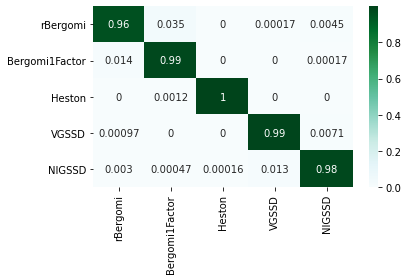

In [10]:
y_pred = model.predict_classes(X_test)

cm = confusion_matrix(y_test_num,y_pred,normalize='true')
df_cm = pd.DataFrame(cm,model_name,model_name)
sns_plot = sns.heatmap(df_cm,annot=True,cmap=plt.cm.BuGn)

sns_plot.figure.tight_layout()

sns_fig = sns_plot.get_figure()
sns_fig.savefig('TestImages/cm_BasePred.png', dpi=300)